In [40]:
import json
import re
import os
from pathlib import Path

import pandas as pd
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tifffile
import torch
import torchvision.transforms.functional as TF
from einops import rearrange
from sklearn.neighbors import NearestNeighbors

In [2]:
%load_ext autoreload

In [3]:
%autoreload 2

In [4]:
import mushroom.utils as utils

In [90]:
metadata = json.load(open('/data/estorrs/mushroom/data/test_registration/HT397B1_v2/registered/metadata.json'))
metadata

{'downsample_scaler': 0.1,
 'phenocycler_pixels_per_micron': 1.9604911906033102,
 'order': ['HT397B1-S1H3A1U1',
  'HT397B1-S1H3A1U2',
  'HT397B1-S1H3A1U12',
  'HT397B1-S1H3A1U21',
  'HT397B1-S1H3A1U22',
  'HT397B1-S1H3A1U31'],
 'data_type': ['visium', 'codex', 'codex', 'visium', 'codex', 'codex'],
 'slices': ['s0', 's1', 's2', 's3', 's4', 's5']}

In [91]:
fps = sorted(utils.listfiles('/data/estorrs/mushroom/data/test_registration/HT397B1_v2/registered',
                             regex=r'/s[0-9]+.*$'))
fps

['/data/estorrs/mushroom/data/test_registration/HT397B1_v2/registered/s0.h5ad',
 '/data/estorrs/mushroom/data/test_registration/HT397B1_v2/registered/s1.ome.tiff',
 '/data/estorrs/mushroom/data/test_registration/HT397B1_v2/registered/s1_codex.h5ad',
 '/data/estorrs/mushroom/data/test_registration/HT397B1_v2/registered/s2.ome.tiff',
 '/data/estorrs/mushroom/data/test_registration/HT397B1_v2/registered/s2_codex.h5ad',
 '/data/estorrs/mushroom/data/test_registration/HT397B1_v2/registered/s3.h5ad',
 '/data/estorrs/mushroom/data/test_registration/HT397B1_v2/registered/s4.ome.tiff',
 '/data/estorrs/mushroom/data/test_registration/HT397B1_v2/registered/s4_codex.h5ad',
 '/data/estorrs/mushroom/data/test_registration/HT397B1_v2/registered/s5.ome.tiff',
 '/data/estorrs/mushroom/data/test_registration/HT397B1_v2/registered/s5_codex.h5ad']

In [111]:
slice_to_st_adata = {}
slice_to_codex_adata = {}
for fp in fps:
    sample = re.sub(r'^(s[0-9]+).*$', r'\1', fp.split('/')[-1])
    if '.h5ad' in fp and 'codex' not in fp:
        slice_to_st_adata[sample] = sc.read_h5ad(fp)
    elif '.h5ad' in fp and 'codex' in fp:
        slice_to_codex_adata[sample] = sc.read_h5ad(fp)
slice_to_st_adata.keys(), slice_to_codex_adata.keys()

(dict_keys(['s0', 's3']), dict_keys(['s1', 's2', 's4', 's5']))

In [112]:
df = pd.read_csv('/data/estorrs/subclone-analyses/data/deconvolution/HT397B1-S1H3A1U1Bp1_RCTD_weights.tsv',
                sep='\t', index_col=0)
df

,Filtered_tumor_regions,boundary_type,RCTD_B-cells,RCTD_Basal_progenitor,RCTD_cDC2,RCTD_Endothelial,RCTD_Fibroblasts,RCTD_Macrophages,RCTD_T-cells,RCTD_Tumor
barcode,,,,,,,,,,
AAACAAGTATCTCCCA-1,0,NaN,0.000000,0.0,0.0,0.000000,1.000000,0.000000,0.0,0.000000
AAACACCAATAACTGC-1,1,NaN,0.000000,0.0,0.0,0.000000,0.038689,0.000000,0.0,0.961311
AAACAGAGCGACTCCT-1,0,NaN,0.000000,0.0,0.0,0.000000,0.252062,0.747938,0.0,0.000000
AAACAGCTTTCAGAAG-1,0,NaN,0.000000,1.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000
AAACAGGGTCTATATT-1,1,NaN,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,1.000000
...,...,...,...,...,...,...,...,...,...,...
TTGTTCAGTGTGCTAC-1,0,NaN,0.034094,0.0,0.0,0.000000,0.261370,0.170592,0.0,0.533944
TTGTTGTGTGTCAAGA-1,0,NaN,0.000000,0.0,0.0,0.000000,0.424745,0.216670,0.0,0.358585
TTGTTTCACATCCAGG-1,0,NaN,0.000000,0.0,0.0,0.144405,0.168424,0.000000,0.0,0.687171


In [113]:
rctd_mapping = {
    'Immune': ['RCTD_B-cells', 'RCTD_cDC2', 'RCTD_Macrophages', 'RCTD_T-cells'],
    'Epithelial': ['RCTD_Tumor', 'RCTD_Basal_progenitor'],
    'Endothelial': ['RCTD_Endothelial'],
    'Fibroblasts': ['RCTD_Fibroblasts']
}
def munge_rctd(df):
    rctd_cols = [c for c in df.columns if 'RCTD' in c]
    rctd = df[rctd_cols]
    
    new = {}
    for k, cols in rctd_mapping.items():
        f = rctd[cols]
        new[k] = f.values.sum(axis=1)
    new = pd.DataFrame.from_dict(new)
    new.columns = [f'rctd_{c}' for c in new.columns]
    new.index = rctd.index.to_list()
    new.index.name = 'barcode'
    return new
    

In [114]:
df = munge_rctd(df)
df

,rctd_Immune,rctd_Epithelial,rctd_Endothelial,rctd_Fibroblasts
barcode,,,,
AAACAAGTATCTCCCA-1,0.000000,0.000000,0.000000,1.000000
AAACACCAATAACTGC-1,0.000000,0.961311,0.000000,0.038689
AAACAGAGCGACTCCT-1,0.747938,0.000000,0.000000,0.252062
AAACAGCTTTCAGAAG-1,0.000000,1.000000,0.000000,0.000000
AAACAGGGTCTATATT-1,0.000000,1.000000,0.000000,0.000000
...,...,...,...,...
TTGTTCAGTGTGCTAC-1,0.204687,0.533944,0.000000,0.261370
TTGTTGTGTGTCAAGA-1,0.216670,0.358585,0.000000,0.424745
TTGTTTCACATCCAGG-1,0.000000,0.687171,0.144405,0.168424


In [115]:
a_st = slice_to_st_adata['s0']
a_st

AnnData object with n_obs × n_vars = 3058 × 17943
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'he_rescaled', 'he_rescaled_warped', 'spatial'
    obsm: 'he_rescaled_spatial', 'spatial', 'spatial_original'

In [116]:
a_st.obs = pd.merge(a_st.obs, df, left_index=True, right_index=True, how='left')
a_st.obs

,in_tissue,array_row,array_col,rctd_Immune,rctd_Epithelial,rctd_Endothelial,rctd_Fibroblasts
AAACAAGTATCTCCCA-1,1,50,102,0.000000,0.000000,0.000000,1.000000
AAACACCAATAACTGC-1,1,59,19,0.000000,0.961311,0.000000,0.038689
AAACAGAGCGACTCCT-1,1,14,94,0.747938,0.000000,0.000000,0.252062
AAACAGCTTTCAGAAG-1,1,43,9,0.000000,1.000000,0.000000,0.000000
AAACAGGGTCTATATT-1,1,47,13,0.000000,1.000000,0.000000,0.000000
...,...,...,...,...,...,...,...
TTGTTCAGTGTGCTAC-1,1,24,64,0.204687,0.533944,0.000000,0.261370
TTGTTGTGTGTCAAGA-1,1,31,77,0.216670,0.358585,0.000000,0.424745
TTGTTTCACATCCAGG-1,1,58,42,0.000000,0.687171,0.144405,0.168424
TTGTTTCCATACAACT-1,1,45,27,0.143208,0.541427,0.115273,0.200092


In [117]:
a_codex = slice_to_codex_adata['s1']
sorted(set(a_codex.obs['cell_type']))

['B cell',
 'CD8 T cell',
 'Endothelial',
 'Epithelial',
 'Immune',
 'Stroma',
 'Treg',
 'Unlabeled']

In [118]:
codex_mapping = {
    'Immune': ['B cell', 'CD8 T cell', 'Immune', 'Treg'],
    'Epithelial': ['Epithelial'],
    'Endothelial': ['Endothelial'],
    'Fibroblasts': ['Stroma']
}
r_codex_mapping = {v:k for k, vs in codex_mapping.items() for v in vs}

In [119]:
r = next(iter(a_st.uns['spatial'].values()))['scalefactors']['spot_diameter_fullres'] / 2
r

63.71596369460758

In [120]:
neigh = NearestNeighbors(radius=r)

In [121]:
neigh.fit(a_codex.obsm['spatial'])

NearestNeighbors(radius=63.71596369460758)

In [122]:
connectivity = neigh.radius_neighbors_graph(a_st.obsm['spatial'])

In [123]:
mask = (connectivity!=0).toarray()
mask

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [124]:
spot_idx_to_cell_idxs = {x:[] for x in np.arange(a_st.shape[0])}
for r, c in np.argwhere(mask>0):
    spot_idx_to_cell_idxs[r].append(c)

In [125]:
from collections import Counter
data = []
order = sorted(codex_mapping.keys())
for i in range(a_st.shape[0]):
    idxs = spot_idx_to_cell_idxs[i]
    counts = Counter([r_codex_mapping.get(c, 0) for c in a_codex[idxs].obs['cell_type']])
    if len(idxs):
        data.append([counts.get(k, 0.) / len(idxs) for k in order])
    else:
        data.append([0. for k in order])
gathered = pd.DataFrame(data=data, columns=[f'codex_{c}' for c in order], index=a_st.obs.index.to_list())
gathered
    

,codex_Endothelial,codex_Epithelial,codex_Fibroblasts,codex_Immune
AAACAAGTATCTCCCA-1,0.000000,0.000000,0.000000,0.000000
AAACACCAATAACTGC-1,0.133333,0.600000,0.266667,0.000000
AAACAGAGCGACTCCT-1,0.150000,0.000000,0.000000,0.250000
AAACAGCTTTCAGAAG-1,0.294118,0.000000,0.058824,0.000000
AAACAGGGTCTATATT-1,0.000000,1.000000,0.000000,0.000000
...,...,...,...,...
TTGTTCAGTGTGCTAC-1,0.000000,0.454545,0.545455,0.000000
TTGTTGTGTGTCAAGA-1,0.000000,0.055556,0.722222,0.055556
TTGTTTCACATCCAGG-1,0.250000,0.000000,0.125000,0.000000
TTGTTTCCATACAACT-1,0.533333,0.000000,0.066667,0.066667


In [127]:
a_st.obs = pd.merge(a_st.obs, gathered, left_index=True, right_index=True, how='left')
a_st.obs

,in_tissue,array_row,array_col,rctd_Immune,rctd_Epithelial,rctd_Endothelial,rctd_Fibroblasts,codex_Endothelial,codex_Epithelial,codex_Fibroblasts,codex_Immune
AAACAAGTATCTCCCA-1,1,50,102,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
AAACACCAATAACTGC-1,1,59,19,0.000000,0.961311,0.000000,0.038689,0.133333,0.600000,0.266667,0.000000
AAACAGAGCGACTCCT-1,1,14,94,0.747938,0.000000,0.000000,0.252062,0.150000,0.000000,0.000000,0.250000
AAACAGCTTTCAGAAG-1,1,43,9,0.000000,1.000000,0.000000,0.000000,0.294118,0.000000,0.058824,0.000000
AAACAGGGTCTATATT-1,1,47,13,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
TTGTTCAGTGTGCTAC-1,1,24,64,0.204687,0.533944,0.000000,0.261370,0.000000,0.454545,0.545455,0.000000
TTGTTGTGTGTCAAGA-1,1,31,77,0.216670,0.358585,0.000000,0.424745,0.000000,0.055556,0.722222,0.055556
TTGTTTCACATCCAGG-1,1,58,42,0.000000,0.687171,0.144405,0.168424,0.250000,0.000000,0.125000,0.000000
TTGTTTCCATACAACT-1,1,45,27,0.143208,0.541427,0.115273,0.200092,0.533333,0.000000,0.066667,0.066667


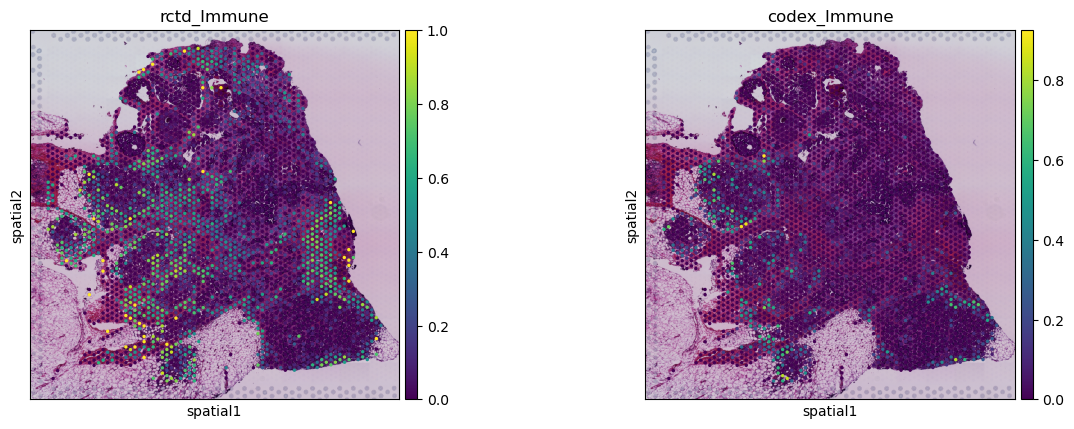

In [128]:
sc.pl.spatial(a_st, color=['rctd_Immune', 'codex_Immune'])

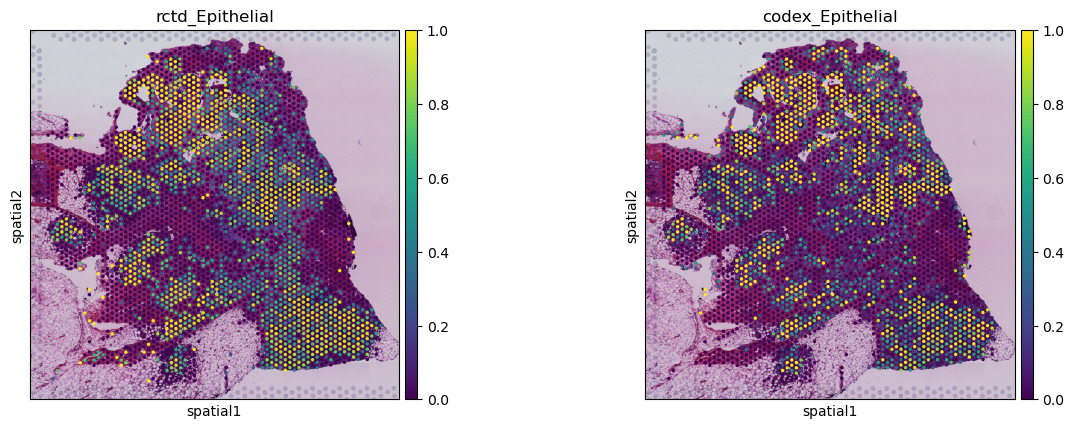

In [129]:
sc.pl.spatial(a_st, color=['rctd_Epithelial', 'codex_Epithelial'])

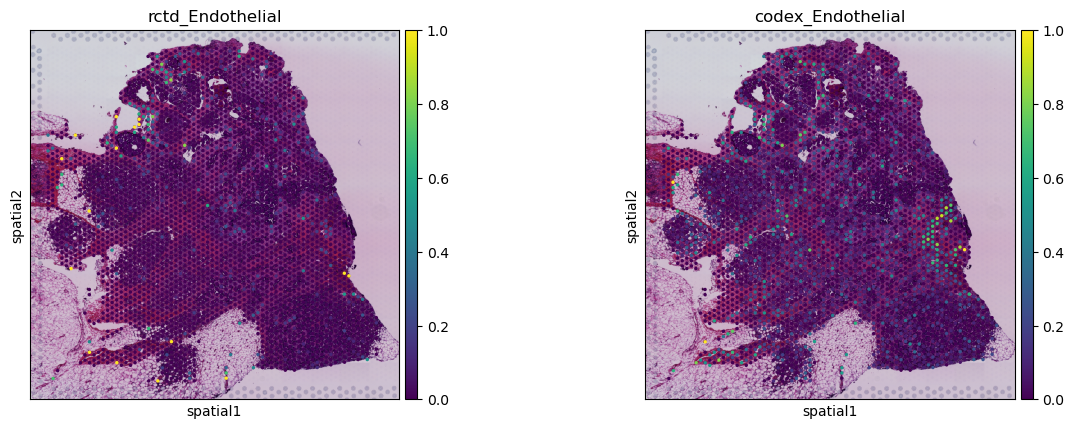

In [130]:
sc.pl.spatial(a_st, color=['rctd_Endothelial', 'codex_Endothelial'])

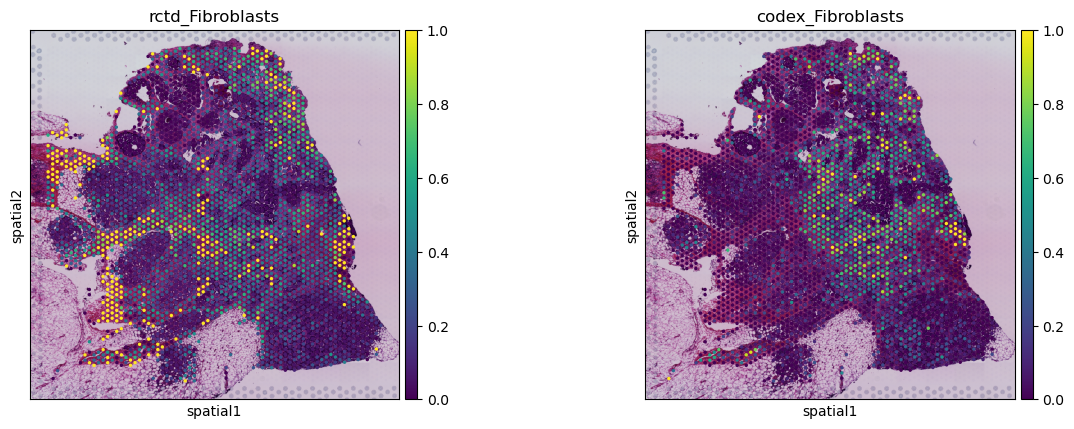

In [132]:
sc.pl.spatial(a_st, color=['rctd_Fibroblasts', 'codex_Fibroblasts'])

###### sanity check

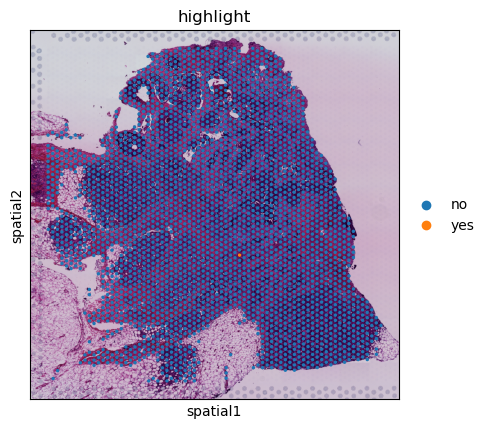

In [67]:
test_idx = 10
a_st.obs['highlight'] = ['yes' if i==test_idx else 'no' for i in range(a_st.shape[0])]
sc.pl.spatial(a_st, color='highlight')

In [68]:
a_codex.obs['highlight'] = ['yes' if i in spot_idx_to_cell_idxs[test_idx] else 'no'
                           for i in range(a_codex.shape[0])]

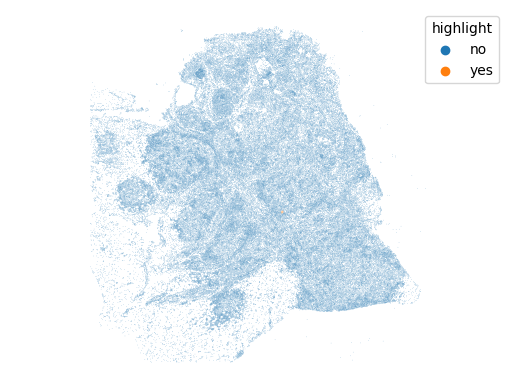

In [78]:
sns.scatterplot(data=a_codex.obs, x='col', y='row', hue='highlight', s=.1)
plt.axis('equal')
plt.axis('off')
plt.gca().invert_yaxis()